### Load models


In [1]:
import os
import sys
import pickle as pkl
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation,gmm_evaluate_with_perturbation3, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp, maxval
from metrics.ood_metrics import get_roc_auc, get_roc_auc_logits

In [2]:
device = torch.device("cuda:0")
# Dataset params
dataset_num_classes = {"cifar10": 10, "CIFAR100": 100, "SVHN": 10, "LSUN": 10, "tiny_iamgenet": 200}

dataset_loader = {"cifar10": cifar10, "CIFAR100": cifar100, "SVHN": svhn, "MNIST": mnist, "LSUN": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512}

batch_size = 512
dataset = "cifar10"
ood_dataset = "CIFAR100"
dataset_root = "../data"
# model = "vgg16"
# saved_model_name = "../saved_models/run38/vgg16_sn_3.0_mod_seed_1/2024_11_26_01_05_50/vgg16_sn_3.0_mod_seed_1_best.model"

model = "resnet50"
saved_model_name = "../saved_models/run42/resnet50_sn_3.0_mod_seed_1/2025_01_10_19_24_27/resnet50_sn_3.0_mod_seed_1_best.model"

# Taking input for the dataset
num_classes = dataset_num_classes[dataset]

In [3]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=batch_size,
    augment=False,
    val_seed=1,
    val_size=0.0,
)

#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

_ = net.load_state_dict(torch.load(str(saved_model_name), map_location=device), strict=True)
_ = net.eval()

load ../saved_models/run42/resnet50_sn_3.0_mod_seed_1/2025_01_10_19_24_27/resnet50_sn_3.0_mod_seed_1_best.model


In [4]:
cache_path = saved_model_name.replace(".model", ".cache")

load_cache = True
if load_cache and os.path.exists(cache_path):
    print(f"load cache from {cache_path}")
    with open(cache_path, 'rb') as file:
        cache = pkl.load(file)
        embeddings = cache["embeddings"].to(device)
        labels = cache["labels"].to(device)
        norm_threshold = cache["norm_threshold"]
else:
    embeddings, labels, norm_threshold = get_embeddings(
        net,
        train_loader,
        num_dim=model_to_num_dim[model],
        dtype=torch.double,
        device=device,
        storage_device=device,
    )
    cache = {"embeddings": embeddings.cpu(), "labels": labels.cpu(), "norm_threshold": norm_threshold}
    with open(cache_path, "wb") as f:
        pkl.dump(cache, f)    
gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)                    

load cache from ../saved_models/run42/resnet50_sn_3.0_mod_seed_1/2025_01_10_19_24_27/resnet50_sn_3.0_mod_seed_1_best.cache


### Compute feature density


In [5]:
all_data  = {}
epsilons ={"CIFAR100": 0.001,"LSUN": 0.001,"MNIST": 0.01,"SVHN": 0.01}
for ood_dataset in ["CIFAR100","LSUN","MNIST","SVHN"]:
# for ood_dataset in ["MNIST"]:
    test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=512,sample_size=1000)
    ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=512,sample_size=1000)
    logits, labels, preds = gmm_evaluate(
        net,
        gaussians_model,
        None,
        test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
    )

    ood_logits, ood_labels, _ = gmm_evaluate(
        net,
        gaussians_model,
        None,
        ood_test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
    )
    m1_fpr95, m1_auroc, m1_auprc = get_roc_auc_logits(logits, ood_logits, maxval, device, conf=True)

    test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1,sample_size=1000)
    ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1,sample_size=1000)
    
    epsilon = epsilons[ood_dataset]
    logits2, labels2, preds2, acc, acc_perturb = gmm_evaluate_with_perturbation(
        net,
        gaussians_model,
        test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
        perturbation="fgsm",
        epsilon=epsilon,
    )
    ood_logits2, ood_labels2, _, _, _ = gmm_evaluate_with_perturbation(
        net,
        gaussians_model,
        ood_test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
        perturbation="fgsm",
        epsilon=epsilon,
    )
    m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(logits2, ood_logits2, maxval, device, conf=True)
    print(f"{ood_dataset},最优:m1_auroc1:{m1_auroc:.4f},m1_auprc:{m1_auprc:.4f};epsilon:{epsilon},m2_auroc:{m2_auroc:.4f},m2_auprc:{m2_auprc:.4f}")
    all_data[ood_dataset] = [logits,ood_logits,logits2,ood_logits2]
    

Files already downloaded and verified


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


Files already downloaded and verified


100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


CIFAR100,最优:m1_auroc1:0.8803,m1_auprc:0.8996;epsilon:0.001,m2_auroc:0.8712,m2_auprc:0.8794


100%|██████████| 1000/1000 [01:49<00:00,  9.14it/s]


LSUN,最优:m1_auroc1:0.9104,m1_auprc:0.9347;epsilon:0.001,m2_auroc:0.9269,m2_auprc:0.9398


100%|██████████| 1000/1000 [01:49<00:00,  9.10it/s]


MNIST,最优:m1_auroc1:0.9133,m1_auprc:0.9423;epsilon:0.01,m2_auroc:0.9594,m2_auprc:0.9727


100%|██████████| 1000/1000 [01:51<00:00,  8.97it/s]

SVHN,最优:m1_auroc1:0.9113,m1_auprc:0.9388;epsilon:0.01,m2_auroc:0.9639,m2_auprc:0.9683


In [6]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})
rc('text', usetex=False)
def plot_density(results, binrange, bins, title, xlabel):

    plt.figure(figsize=(5, 3))
    plt.tight_layout()

    plt.hist(results[0], density=True, color='r', range=binrange, bins=bins, alpha=0.5, label="org")
    plt.hist(results[1], density=True, color='b', range=binrange, bins=bins, alpha=0.5, label="ood")

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Fraction', fontsize=12)
    plt.title(label=title)
    plt.legend()

if not os.path.exists(f"pngs/{model}"):
    os.makedirs(f"pngs/{model}")

for idx,ood_dataset in enumerate(["CIFAR100","LSUN","MNIST","SVHN"]):
    logits,logits2,ood_logits,ood_logits2 = all_data[ood_dataset]
    logp =  maxval(logits)
    logp2 = maxval(logits2)
    ood_logp = maxval(ood_logits)
    ood_logp2 = maxval(ood_logits2)

    # left1 = int(min(logp.quantile(0.).item(), ood_logp.quantile(0.).item()))
    # right1 = int(max(logp.quantile(1).item(), ood_logp.quantile(1).item()))
    # plot_density([logp.cpu().numpy(), ood_logp.cpu().numpy()],
    #             binrange=[left1 - 100, right1 + 100],
    #             bins=100,
    #             title="without perturbation",
    #             xlabel="log density")
    # plt.savefig(f'pngs/{model}/{ood_dataset}_logdensity_hist.png', bbox_inches='tight')
    # left2 = int(min(logp2.quantile(0).item(), ood_logp2.quantile(0.).item()))
    # right2 = int(max(logp2.quantile(1).item(), ood_logp2.quantile(1).item()))
    # plot_density([logp2.cpu().numpy(), ood_logp2.cpu().numpy()],
    #             binrange=[left2 - 100, right2 + 100],
    #             bins=100,
    #             title="perturbation",
    #             xlabel="log density")
    # plt.savefig(f'pngs/{model}/{ood_dataset}_logdensity_hist_purturbation.png', bbox_inches='tight')

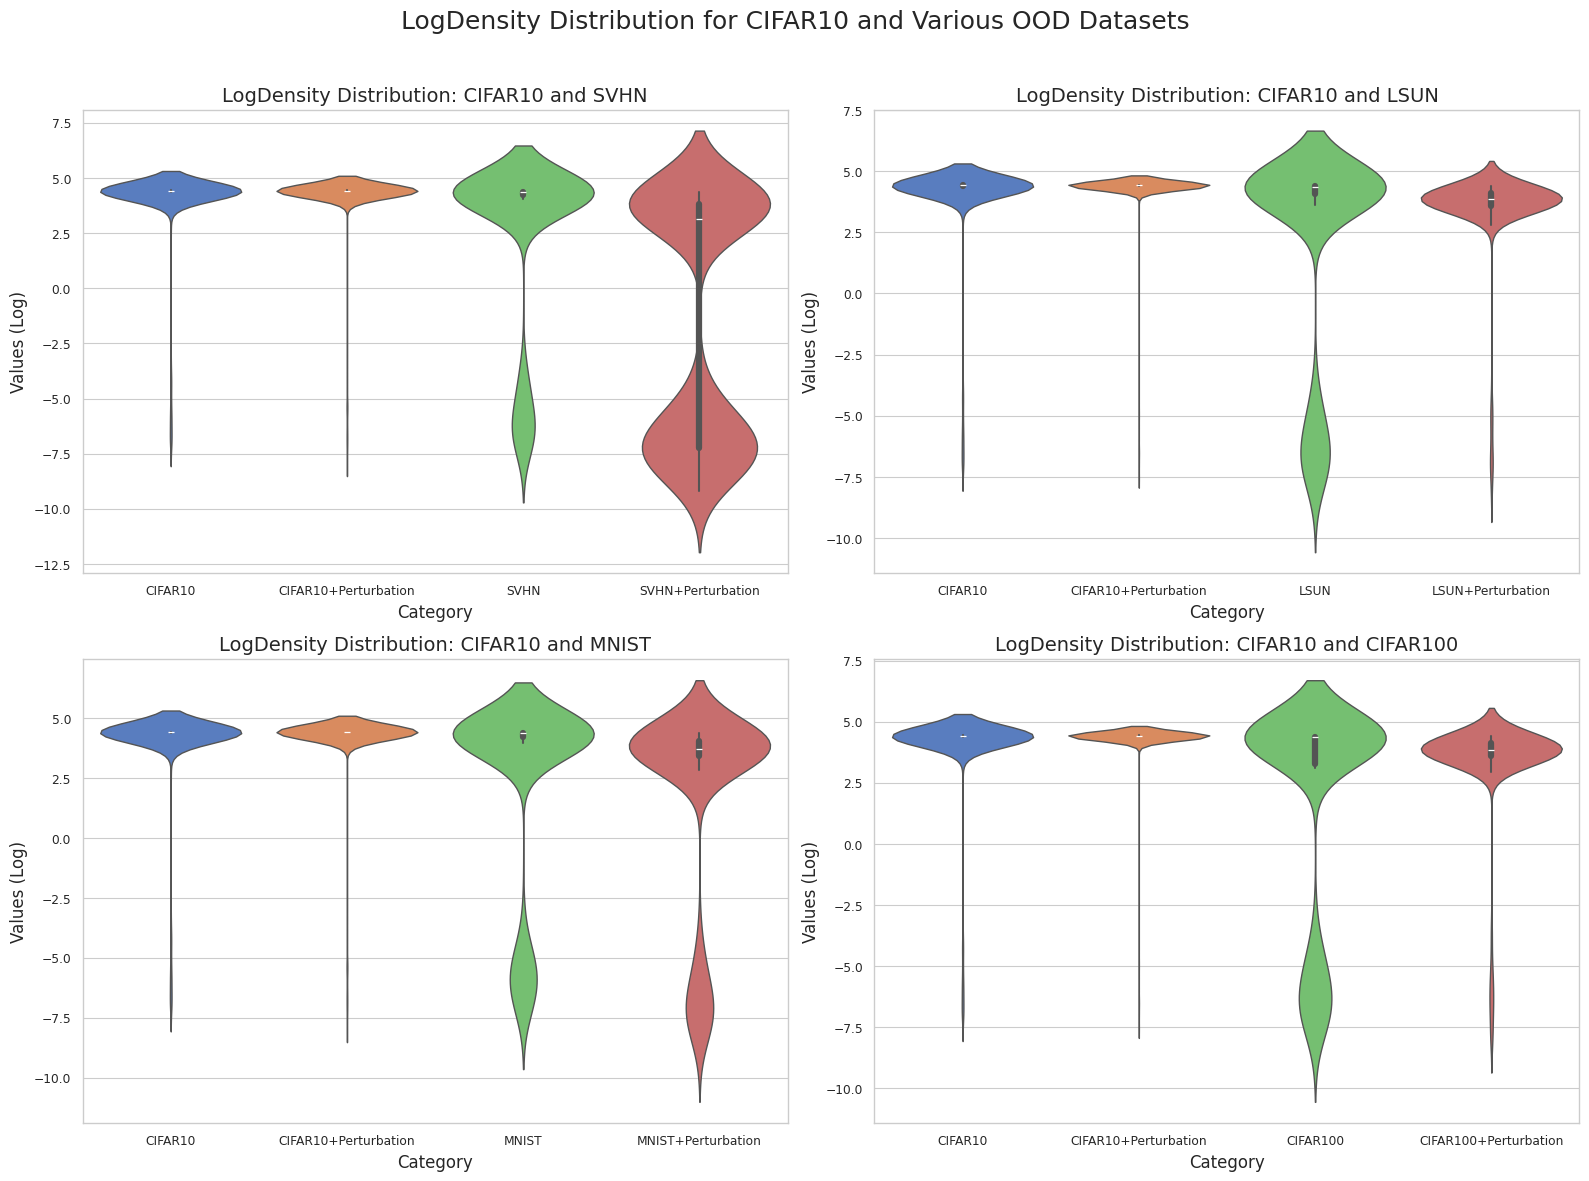

In [7]:
# 创建一个包含 4 个子图的画布
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=False, sharey=False)
axes = axes.flatten()  # 将 axes 转为一维数组，方便迭代
for idx,ood_dataset in enumerate(["SVHN","LSUN","MNIST","CIFAR100"]):
    logits,logits2,ood_logits,ood_logits2 = all_data[ood_dataset]
    logp =  maxval(logits)
    logp2 = maxval(logits2)
    ood_logp = maxval(ood_logits)
    ood_logp2 = maxval(ood_logits2)
    x1= np.sign(logp.cpu().numpy()) * np.log10(np.abs(logp.cpu().numpy()))  # 零值单独处理
    x2= np.sign(logp2.cpu().numpy()) * np.log10(np.abs(logp2.cpu().numpy()))  # 零值单独处理
    x3= np.sign(ood_logp.cpu().numpy()) * np.log10(np.abs(ood_logp.cpu().numpy()))  # 零值单独处理
    x4= np.sign(ood_logp2.cpu().numpy()) * np.log10(np.abs(ood_logp2.cpu().numpy()))-np.random.rand(1000)  # 零值单独处理
    
    data = {
        "Values": np.concatenate([x1,x3,x2,x4]),
        "Category": np.repeat(['CIFAR10','CIFAR10+Perturbation', f'{ood_dataset}', f'{ood_dataset}+Perturbation'],1000)
    }
    df = pd.DataFrame(data)

      # 绘制小提琴图
    sns.violinplot(
        x='Category', y='Values', hue='Category', data=df, palette='muted', inner='box', ax=axes[idx]
    )

    # 设置标题和标签
    axes[idx].set_title(f'LogDensity Distribution: CIFAR10 and {ood_dataset}', fontsize=14)
    axes[idx].set_xlabel('Category', fontsize=12)
    axes[idx].set_ylabel('Values (Log)', fontsize=12)

    # 移除子图中的图例（避免重复）
    # axes[idx].get_legend().remove()

# 添加全局标题
fig.suptitle('LogDensity Distribution for CIFAR10 and Various OOD Datasets', fontsize=18)

# 调整子图布局
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 保存图片
plt.savefig(f'pngs/{model}/logdensity_violin_purturbation_combined.png', bbox_inches='tight')

# 显示图形
plt.show()

In [ ]:
data = {
    "Values": np.concatenate([logp.cpu().numpy(),  ood_logp.cpu().numpy(),logp2.cpu().numpy(),ood_logp2.cpu().numpy()]),
    "Category": np.repeat(['logp', 'ood_logp', 'logp+ip', 'ood_logp+ip'],1000)
}
df = pd.DataFrame(data)

# 绘制小提琴图
plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Values', hue='Category', data=df, palette='muted', inner='box', legend=True)
# sns.boxplot(x='Category', y='Values', hue='Category',data=df, palette='muted')

# 添加标题和标签
plt.title('Violin Plot for logp and ood_logp', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Values', fontsize=12)

# 显示图表
plt.show()

In [ ]:
data = {
    "Values": np.concatenate([logp.cpu().numpy(),  ood_logp.cpu().numpy(),logp2.cpu().numpy(),ood_logp2.cpu().numpy()]),
    "Category": np.repeat(['logp', 'ood_logp', 'logp+ip', 'ood_logp+ip'],1000)
}
df = pd.DataFrame(data)

# 绘制箱线图
plt.figure(figsize=(10, 6))
# sns.violinplot(x='Category', y='Values', hue='Category', data=df, palette='muted', inner='quartile', legend=False)
sns.boxplot(x='Category', y='Values', hue='Category',data=df, palette='muted',showmeans=True,)

# 添加标题和标签
plt.title('Violin Plot for logp and ood_logp', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Values', fontsize=12)

# 显示图表
plt.show()

In [ ]:
ood_diff = ood_logp2-ood_logp
sns.boxplot(data=ood_diff.cpu().numpy())

# 添加图标题和标签
plt.title("Boxplot of Data")
plt.xlabel("Values")

# 显示图形
plt.show()

In [ ]:
diff = logp2-logp
sns.boxplot(data=diff.cpu().numpy())

# 添加图标题和标签
plt.title("Boxplot of Data")
plt.xlabel("Values")

# 显示图形
plt.show()

In [ ]:
diff

In [ ]:
diff[diff<0].shape[0]/1000

In [ ]:
ood_diff

In [ ]:
ood_diff[ood_diff<0].shape[0]/1000